# Lab 2 - Time Series Forecasting Model

This Jupyter notebook will show you how to use an API call to extract a time series dataset (at half hourly granularity) from the WPD connected data portal. Subsequently, an example of how the dataset can be visualised utilising pandas will follow. Finally, the Light Gradient Boosting Machine package will enable us to train and test a model that will be used estimate a forecast for a pre-defined horizon.

### Import required modules

In [438]:
import urllib3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgbm
import json

In [547]:
from IPython.display import display
from matplotlib.dates import DateFormatter
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error

### Loading Dataset via API

WPD's connected data portal is a rich and diverse repository of datasets that is constantly growing and evolving. One of the key benefits of the portal is that it enables API requests. The dataset we will be utilising for this lab is a time series dataset for the Sowton 11kV transformer flows from 31/03/2019 to 01/04/2021.

In [514]:
# Create a PoolManager instance for sending requests.
http = urllib3.PoolManager()

# This is the dataset url
url = 'https://connecteddata.westernpower.co.uk/api/3/action/datastore_search?resource_id=b00563eb-17f5-41ea-8d33-195720d614a7&limit=32000'
# Calls the endpoint
response = http.request('GET',url)

# Use the json module to load CKAN's response into a dictionary.
response_dict = json.loads(response.data)

# Display the first record in the response
display(response_dict['result']['records'][0])

{'_id': 1,
 'Timestamp': '2019-03-31T00:30:00',
 'T1_Demand_MW': 2.84,
 'T1_Demand_MVAr': 0.0,
 'T1_Demand_MVA': 2.84,
 'T1_Import_MW': 2.84,
 'T1_Import_MVAr': 0.0,
 'T1_Import_MVA': 2.84,
 'T2_Demand_MW': 2.84,
 'T2_Demand_MVAr': 0.0,
 'T2_Demand_MVA': 2.84,
 'T2_Import_MW': 2.84,
 'T2_Import_MVAr': 0.0,
 'T2_Import_MVA': 2.84}

### Assign Dataframe & Initial Investigation

An initial inspection of the dataset reveals that the rows aren't ordered correctly; the first discrepancy is located at row 83. Sorting the dataset via the _id column will solve this issue. However, because the API call has only pulled through 32,000 rows and not the entire dataset, we will need to trim it at the first discrepancy in the sorted dataset. This will ensure that any outliers are removed.

In [591]:
#Assign the dataset dictionary to a dataframe
df = pd.DataFrame(response_dict['result']['records'])

def dataframe_manipulation_investigation(df):
    #Check if the dataset is ordered correctly by creating a timeseries using the date_range function
    x = pd.date_range(min(df.Timestamp), max(df.Timestamp), freq='30min')
    display(len(x),len(df.Timestamp))

    #Compare the timeseries with the Timestamp of the dataset and return the row indexes that are correctly ordered
    list = x[0:len(df.Timestamp)] == df.Timestamp
    print([i for i, x in enumerate(list) if x])

    #Sort the dataframe via the _id column
    df.sort_values(by=['_id'], inplace=True)

    #Compare the timeseries with the Timestamp of the dataset and return the row indexes that are correctly ordered
    list = x[0:len(df.Timestamp)] == df.Timestamp
    cut_off = [i for i, x in enumerate(list) if x][-1]
    df = df.loc[:cut_off, :]
    
    return df

df = dataframe_manipulation_investigation(df)
display(df)

#Statistical investigation of the dataset
display(df.describe().T)

34592

32000

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82]


,_id,Timestamp,T1_Demand_MW,T1_Demand_MVAr,T1_Demand_MVA,T1_Import_MW,T1_Import_MVAr,T1_Import_MVA,T2_Demand_MW,T2_Demand_MVAr,T2_Demand_MVA,T2_Import_MW,T2_Import_MVAr,T2_Import_MVA
0,1,2019-03-31T00:30:00,2.840,0.000,2.840000,2.840,0.000,2.840000,2.840,0.000,2.840000,2.840,0.000,2.840000
1,2,2019-03-31T01:00:00,2.880,0.740,2.973550,2.880,0.740,2.973550,2.840,0.560,2.894685,2.840,0.560,2.894685
2,3,2019-03-31T01:30:00,-0.003,0.003,0.004243,-0.003,0.003,0.004243,-0.003,0.003,0.004243,-0.003,0.003,0.004243
3,4,2019-03-31T02:00:00,-0.003,0.003,0.004243,-0.003,0.003,0.004243,-0.003,0.003,0.004243,-0.003,0.003,0.004243
4,5,2019-03-31T02:30:00,2.870,0.830,2.987608,2.870,0.830,2.987608,2.790,0.000,2.790000,2.790,0.000,2.790000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31960,31920,2021-01-24T00:00:00,3.090,0.720,3.172775,3.090,0.720,3.172775,3.060,0.000,3.060000,3.060,0.000,3.060000
31961,31921,2021-01-24T00:30:00,3.000,0.660,3.071742,3.000,0.660,3.071742,2.990,0.680,3.066350,2.990,0.680,3.066350
31962,31922,2021-01-24T01:00:00,2.950,0.000,2.950000,2.950,0.000,2.950000,2.960,0.000,2.960000,2.960,0.000,2.960000
31963,31923,2021-01-24T01:30:00,2.950,0.000,2.950000,2.950,0.000,2.950000,2.960,0.000,2.960000,2.960,0.000,2.960000


,count,mean,std,min,25%,50%,75%,max
_id,31924.0,15962.500000,9215.809333,1.000,7981.75000,15962.500000,23943.250000,31924.000000
T1_Demand_MW,31924.0,4.009753,0.949120,-0.003,3.33000,3.970000,4.680000,11.330000
T1_Demand_MVAr,31924.0,0.859507,0.372570,0.000,0.66000,0.880000,1.100000,2.560000
T1_Demand_MVA,31924.0,4.109429,0.984425,0.000,3.40689,4.071560,4.805851,11.611223
T1_Import_MW,31924.0,4.009753,0.949120,-0.003,3.33000,3.970000,4.680000,11.330000
T1_Import_MVAr,31924.0,0.859507,0.372570,0.000,0.66000,0.880000,1.100000,2.560000
T1_Import_MVA,31924.0,4.109429,0.984425,0.000,3.40689,4.071560,4.805851,11.611223
T2_Demand_MW,31924.0,3.983433,0.954459,-0.003,3.30000,3.930000,4.640000,11.910000
T2_Demand_MVAr,31924.0,0.730099,0.377064,-1.180,0.54000,0.760000,0.980000,2.740000
T2_Demand_MVA,31924.0,4.059410,0.987491,0.000,3.35000,4.008616,4.738088,12.221117


### Choose Feature to Forecast and Manipulating the Dataframe

When a particular feature is chosen for forecasting, it is important to remove the remaining and redundant features. The horizon values for these features will also be unknown, therefore they cannot be passed to the LGBMRegressor model. Moreover, it is obligatory for model classes that the 'Timestamp' column is converted to the datetime format and set as the indices for the dataframe. Finally, adding hour, day, month and year variables will ensure the seasonal patterns are analysed when training the LGBMRegressor model.

,T1_Demand_MVA,hour,day,month
Timestamp,,,,
2019-03-31 00:30:00,2.840000,0,31,3
2019-03-31 01:00:00,2.973550,1,31,3
2019-03-31 01:30:00,0.004243,1,31,3
2019-03-31 02:00:00,0.004243,2,31,3
2019-03-31 02:30:00,2.987608,2,31,3
...,...,...,...,...
2021-01-24 00:00:00,3.172775,0,24,1
2021-01-24 00:30:00,3.071742,0,24,1
2021-01-24 01:00:00,2.950000,1,24,1


Text(0, 0.5, 'T1 Demand MVA')

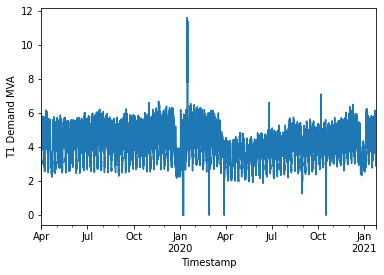

In [576]:
#Choose what feature to forecast
feature_to_forecast = 'T1_Demand_MVA'
feature_name = 'T1 Demand MVA' #Allows automatic application of y-axis labels

#Remove redundant features
df = df[["Timestamp", feature_to_forecast]]

#convert datetime from object to datetime type
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

#set the Timestamp column as the index of the dataframe and then drop it
df = df.set_index(df.Timestamp)
df.drop('Timestamp', axis=1, inplace=True)

#create hour, day, month and year variables from datetime index
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
display(df)

#Visualise the time series data for the chosen feature
df[feature_to_forecast].plot()
plt.ylabel(feature_name)

### Function for decomposing the seasonality of the dataset and visualising it

Decomposing and understanding the seasonality of the data is a key component in building an accurate forecasting model. The function below makes use of the seasonal_decompose function from the statsmodels package. The decompose seasonality function takes the dataset, a sample length and value for the period as arguements. The sample length can be adjusted to investigate and visualise the seasonality of the dataset at different 'seasons'. For example, passing a weeks worth of data from the dataset can identify daily patterns in the chosen feature. Note, it is required that the sample length is two times the period.

In [577]:
def decompose_seasonality(df, feature_to_forecast, sample_len, period):
    if sample_len == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[feature_to_forecast].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[feature_to_forecast].values[-sample_len:], period=period)

    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid

    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,14))
    axs[0].set_title('OBSERVED', fontsize=12)
    axs[0].plot(observed)
    axs[0].grid()

    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=12)
    axs[1].plot(trend)
    axs[1].grid()

    #plot the seasonality of the time series. Period=47 daily seasonality | Period=47*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=12)
    axs[2].plot(seasonal)
    axs[2].grid()

    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=12)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()

    plt.show()

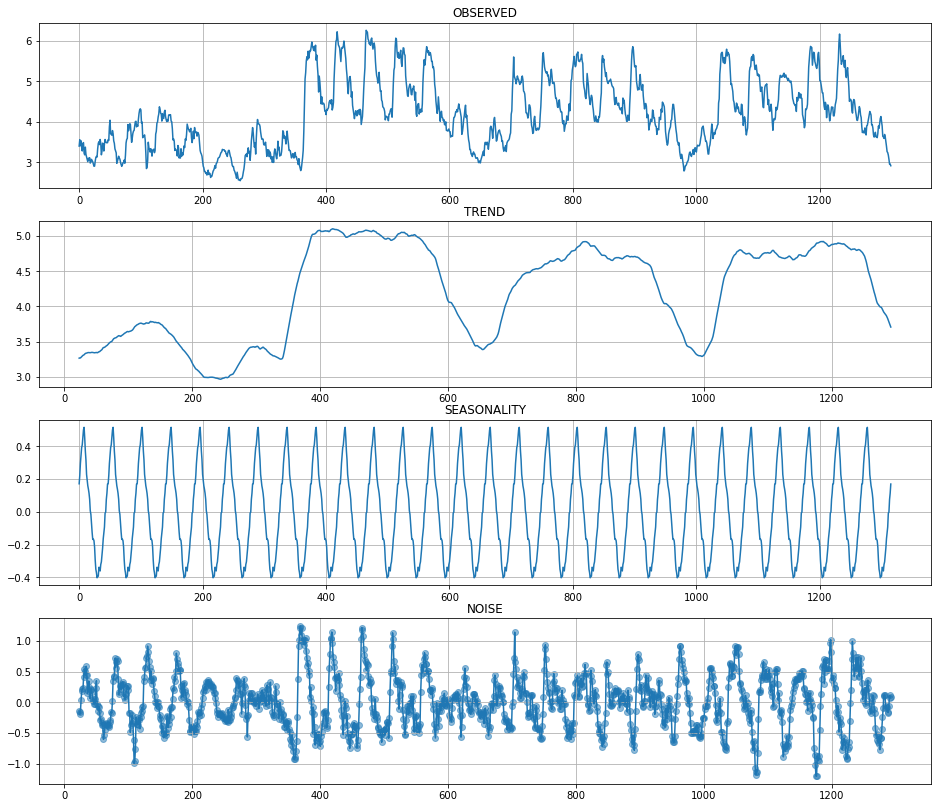

In [578]:
#Decompose the seasonality components + trend of the data feature chosen to forecast
period = 47 #one day is 47 30-mins
seasonality_window_len = period*7*4 #one months worth - weekly trend can be visualised
decompose_seasonality(df, feature_to_forecast, seasonality_window_len, 47)

### Lag Variable to Improve Model Performance

Adding a lag varible will add a feature to the dataset that will provide a robust estimate of the effects of independent variables. The importance of this feature relative to the other features is visualised below.

In [579]:
#create 1 week lag variable by shifting the target value for 1 week
df['Lag variable'] = df[feature_to_forecast].shift(47*7)

#drop NaNs after feature engineering
df.dropna(how='any', axis=0, inplace=True)

### Train and Test Data for the Model

In order to quantify the performance of the LGBMRegressor, we need to separate the dataset into train and test data. The train set will incorporate the majorty of the original dataset as it will be used to train the LGBMRegressor model. Moreover, the test dataset will be used to test the LGBMRegressor model performance.

In [580]:
#Set y (response variable) and X (explanatory variable)
#y contains the feature we are hoping to forecast, X contains all the other features
X = df.drop(feature_to_forecast, axis=1)
y = df[feature_to_forecast]

#Use the 4 weeks of the dataset as test data to gain insight on performance
test_len = 4*7*47
X_train, X_test = X.iloc[:-test_len,:], X.iloc[-test_len:,:]
y_train, y_test = y.iloc[:-test_len], y.iloc[-test_len:]

### Declare Model, Predict Test Data and Visualise

The LGBMRegressor model is assigned and wrapped into a function that takes X_train, y_train and X_test as arguements. More information on the Light Gradient Boosting Machine LGBMRegressor can be found here: https://lightgbm.readthedocs.io/en/latest/Python-Intro.html#install.

The feature importance figure quantifies the importance of the features (or explanatory variables) passed in the training dataset. This can be used to quantify the importance of any additional features. For example, rainfall or electricity price data could be used to improve the LGBMRegressor model. The importance of these new features could then later be visualised.

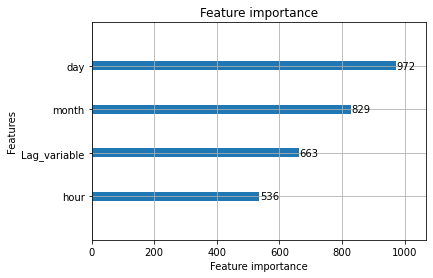

In [581]:
#create, train and do inference of the model
def LGBMmodel(X_train, y_train, X_test):
    #initialise the model
    model = lgbm.LGBMRegressor()
    #fit the train datasets to the model
    model.fit(X_train, y_train)
    #predict y_test using X_test
    predictions = model.predict(X_test)
    #plot the importance of X_train features
    lgbm.plot_importance(model)
    
    return model, predictions

model, predictions = LGBMmodel(X_train, y_train, X_test)

### Plotting forecast and test to visualise accuracy

The MAE (mean absolute error) is used to quantify the LGBMRegressor's ability to reproduce the test data.

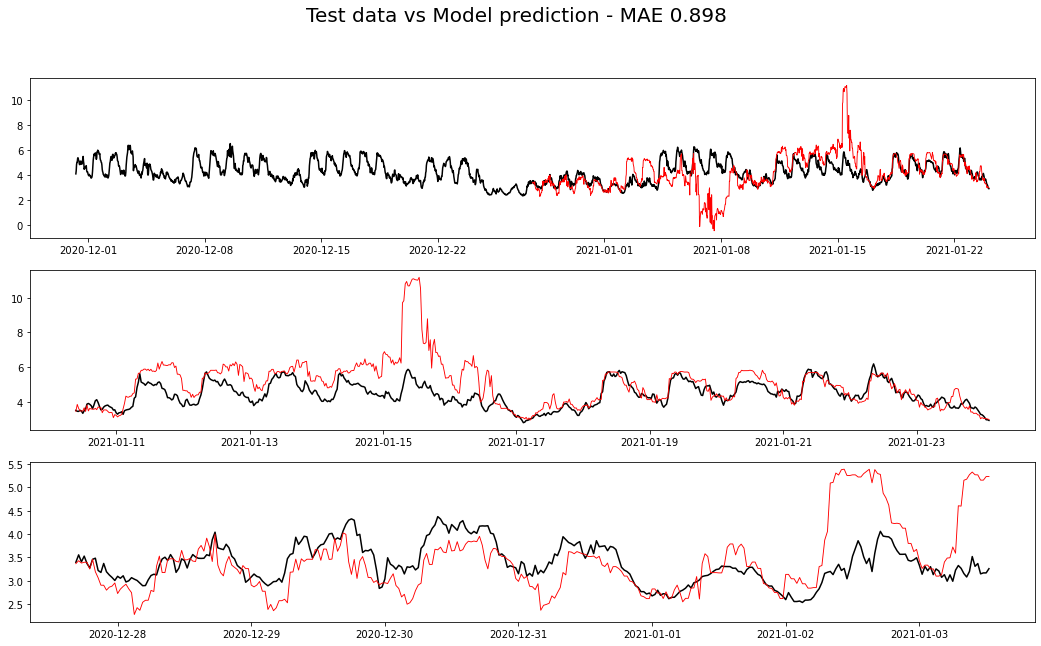

In [582]:
fig, axs = plt.subplots(3, figsize=(18,10))

#Add title that includes Mean Absolute Error of model predicition
mae = np.round(mean_absolute_error(y_test, predictions), 3)
fig.suptitle(f'Test data vs Model prediction - MAE {mae}', fontsize=20)

#plot all test prediction
axs[0].plot(y_train[-test_len:], color='k')
axs[0].plot(y_test[:], color='k')
axs[0].plot(pd.Series(predictions, index=y_test.index), color='r', linewidth = 0.9)

#plot half of the test prediction - end
axs[1].plot(y_test[-round(test_len/2):], color='k')
axs[1].plot(pd.Series(predictions[-round(test_len/2):], index=y_test[-round(test_len/2):].index), color='r', linewidth = 0.9)

#plot quarter of the test prediction - start
axs[2].plot(y_test[0:round(test_len/4)], color='k')
axs[2].plot(pd.Series(predictions[0:round(test_len/4)], index=y_test[0:round(test_len/4)].index), color='r', linewidth = 0.9)

### Utilise Model to Forecast Horizon/Future

In order to forecast for a pre-defined horizon, we need to extend the data set, thus utilising all of the historic data to train the LGBMRegressor model. The test data set includes null values that act as a placeholder for the LGBMRegressor model.

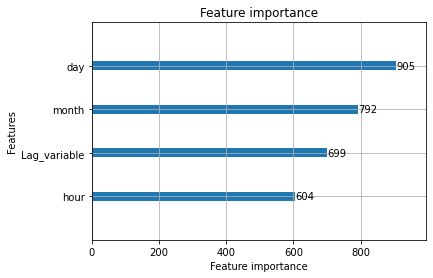

In [583]:
#Reformat X and y in order to add room for prediciton
X_train = X
y_train = y

#Reload the dataset - we need the Timestamp column back to extend the dataset for the horizon period
h_df = pd.DataFrame(response_dict['result']['records'])
h_df = dataframe_manipulation_investigation(h_df)
h_df = h_df[["Timestamp", feature_to_forecast]]

#Convert datetime from object to datetime type
h_df['Timestamp'] = pd.to_datetime(h_df['Timestamp'])

#Add horizon window to the end of data frame in order to allow room for forecasting
num_weeks = 1 #horizon length = 4 weeks
horizon_len = num_weeks*7*47 #47 half-hours in one day

for i in range(horizon_len):
    h_df.loc[cut_off+i] = [h_df.iloc[-1,0] + timedelta(minutes=30), np.nan]

#Set datetime as index
h_df = h_df.set_index(h_df.Timestamp)
#Drop datetime column
h_df.drop('Timestamp', axis=1, inplace=True)

#create hour, day and month variables from datetime index
h_df['hour'] = h_df.index.hour
h_df['day'] = h_df.index.day
h_df['month'] = h_df.index.month
X_test = h_df

#Create 1 week lag variable by shifting the target value for 1 week
X_test['Lag variable'] = X_test[feature_to_forecast].shift(horizon_len)
X_test['Lag variable'] = pd.to_numeric(X_test['Lag variable'])

#Drop NaNs from lag variable column only
X_test.dropna(subset=['Lag variable'], how='any', axis=0, inplace=True)
X_test = X_test.drop(feature_to_forecast, axis=1).iloc[-horizon_len:,:]
y_test = h_df[feature_to_forecast].iloc[-horizon_len:]

forecast_model, forecast_predictions = LGBMmodel(X_train, y_train, X_test)

### Plot historical dataset and predicted horizon forecast

The end of the historical dataset is plotted alongside the prediction for the pre-defined horizon from the LGBMRegressor model.

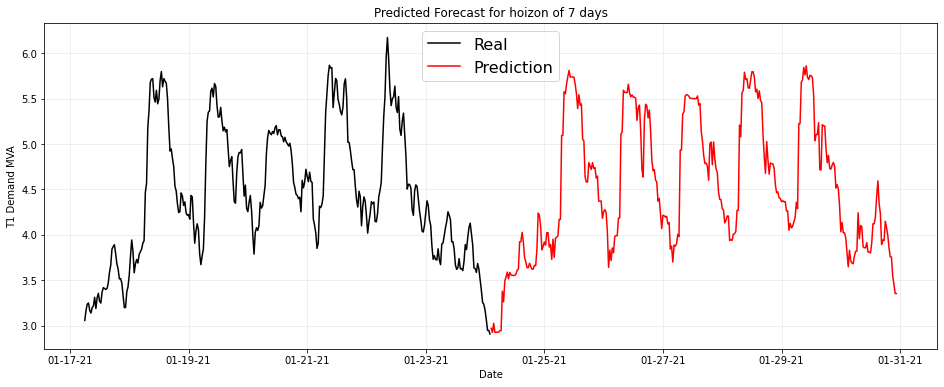

In [585]:
fig, ax = plt.subplots(figsize=(16,6))

ax.set(xlabel='Date', ylabel=f'{feature_name}', title=f'Predicted Forecast for hoizon of {round(horizon_len/47)} days')
ax.plot(y_train[-horizon_len:], color='k')
ax.plot(pd.Series(forecast_predictions, index=y_test.index), color='r')
ax.plot()
ax.legend(labels=['Real', 'Prediction'], fontsize=16)
# Define the date format
date_form = DateFormatter("%m-%d-%y")
ax.xaxis.set_major_formatter(date_form)

plt.grid(alpha=0.25)
plt.show()

### Prediction for a specific datetime in the horizon

In [592]:
#Assign the output of the LGBMRegressor model to a variable
x = y_test.index
y = pd.Series(forecast_predictions, index=y_test.index)

In [593]:
display(f'The Demand (MVA) through T1 at {x[76]} is {np.round(y[76],2)}')

'The Demand (MVA) through T1 at 2021-01-25 16:30:00 is 4.64'